In [ ]:
!pip install tensorflow_text

### Utilization of tensorflow Hub to leverage pre-trained BERT models for text classification

In [ ]:
import tensorflow as tf
import tensorflow_hub as text
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd
df=pd.read_csv("spam.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [ ]:
## unbalanced dataset-downsampling(easy method)
df_ham=df[df['label']=='ham']
df_ham.shape


(3672, 4)

In [ ]:
df_spam=df[df['label']=='spam']
df_spam.shape


(1499, 4)

In [ ]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1499, 4)

In [ ]:
df_balanced=pd.concat([df_ham_downsampled,df_spam])
df_balanced.shape

(2998, 4)

In [ ]:
df_balanced['label'].value_counts()

ham     1499
spam    1499
Name: label, dtype: int64

In [ ]:
 from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test=train_test_split(df_balanced['text'],df_balanced['label_num'], stratify=df_balanced['label'])

In [ ]:
df_balanced.shape

(2998, 4)

In [ ]:
X_train=X_train.str.replace('Subject:'," ")
X_train.head()

231       c , | alis soft ` tabs , fast shipping `\r\n...
4904      daren ,\r\ni have no problem sticking around...
4505      no , i am real confused .\r\nthe onl * ine s...
3372      inexplicable crying spells , sadness and / o...
3155      txu gas distribution deal # 646679\r\nplease...
Name: text, dtype: object

BERT

In [ ]:
bert_preprocess=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
## try with an example

def get_sentence_embedding(sentence):
  preprocessed_text=bert_preprocess(sentence)
  return bert_encoder(preprocessed_text)

get_sentence_embedding(['hi bill',' I iike playiung'])


{'sequence_output': <tf.Tensor: shape=(2, 128, 768), dtype=float32, numpy=
 array([[[ 0.0412035 ,  0.34257308, -0.18548623, ..., -0.17405242,
           0.00598939,  0.07412153],
         [ 0.2313804 ,  0.00645972,  0.68863857, ..., -0.06295711,
           0.21765035, -0.8602514 ],
         [ 0.3803552 , -0.6135296 ,  0.24269846, ...,  0.85957   ,
           0.01383325, -0.5160356 ],
         ...,
         [-0.17007382,  0.36189058,  0.8132361 , ...,  0.18827972,
          -0.04361098, -0.11537205],
         [-0.33499968, -0.35951576,  0.3797515 , ...,  0.5989379 ,
          -0.0858556 , -0.32428998],
         [-0.203864  ,  0.15042508,  0.77139854, ...,  0.15890062,
           0.02269278, -0.165168  ]],
 
        [[-0.5124443 ,  0.08093267, -0.61858475, ..., -0.2074132 ,
           0.06316054,  0.51839876],
         [-0.32319286,  0.10605142,  0.09032454, ..., -0.1891659 ,
           0.25386202,  0.68367237],
         [-0.72004294, -0.17296304,  0.06877096, ..., -0.55400866,
         

In [ ]:
##Bert Layer

text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

In [ ]:
## Neural network layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1, activation ='sigmoid', name='output')(l)

In [ ]:
##final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
metrics=[tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Recall(name='Recall')]

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=metrics)

In [ ]:
##train the model

model.fit(X_train,y_train,epochs=7)

Epoch 1/7
71/71 [==============================] - 1126s 16s/step - loss: 0.6689 - Accuracy: 0.5974 - precision: 0.5942 - Recall: 0.6148
Epoch 2/7
71/71 [==============================] - 1122s 16s/step - loss: 0.5758 - Accuracy: 0.6975 - precision: 0.7106 - Recall: 0.6664
Epoch 3/7
71/71 [==============================] - 1120s 16s/step - loss: 0.5263 - Accuracy: 0.7607 - precision: 0.7584 - Recall: 0.7651
Epoch 4/7
71/71 [==============================] - 1113s 16s/step - loss: 0.4866 - Accuracy: 0.8034 - precision: 0.8123 - Recall: 0.7891
Epoch 5/7
71/71 [==============================] - 1114s 16s/step - loss: 0.4538 - Accuracy: 0.8243 - precision: 0.8359 - Recall: 0.8069
Epoch 6/7
71/71 [==============================] - 1112s 16s/step - loss: 0.4286 - Accuracy: 0.8439 - precision: 0.8549 - Recall: 0.8283
Epoch 7/7
71/71 [==============================] - 1108s 16s/step - loss: 0.4100 - Accuracy: 0.8519 - precision: 0.8599 - Recall: 0.8407


In [ ]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 367s 15s/step - loss: 0.3753 - Accuracy: 0.8813 - precision: 0.9181 - Recall: 0.8373


[0.3753340244293213,
 0.8813333511352539,
 0.9181286692619324,
 0.8373333215713501]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

24/24 [==============================] - 367s 15s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[347,  28],
       [ 61, 314]])

Text(50.722222222222214, 0.5, 'Truth')

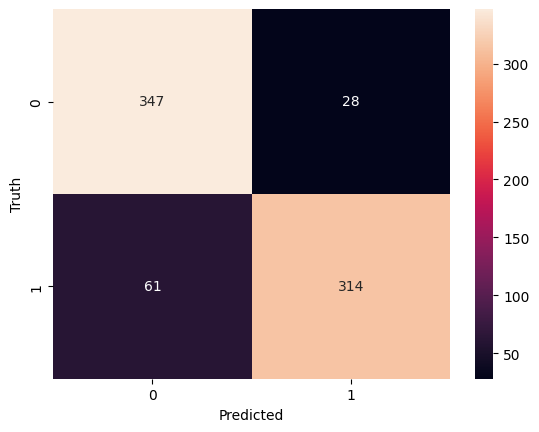

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       375
           1       0.92      0.84      0.88       375

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750



In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.54944855],
       [0.5168919 ],
       [0.45613557],
       [0.7791536 ],
       [0.87253696]], dtype=float32)